## 1. Import Libraries

In [1]:
import math
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime as dt
from binance import Client
import csv
import warnings
import os
warnings.filterwarnings("ignore")

## 2. Fetch Cryptocurrencies Data

In [2]:
# Configuración del cliente de Binance
client = Client(None, None)

# Lista de criptomonedas a analizar
cryptos = ["ETHUSDT", "LTCUSDT", "ADAUSDT", "XRPUSDT"]

# Funciones para obtener y guardar datos
def getdata(symbol, period, start, end):
    return client.get_historical_klines(symbol, period, start, end)

def make_csv(symbol, candles):
    with open("historical/"+symbol + ".csv", "w", newline="") as csvfile:
        cursor = csv.writer(csvfile)
        cursor.writerows(candles)

def multiple_csv(symbols, interval, start, end):
    for symbol in symbols:
        make_csv(symbol, getdata(symbol, interval, start, end))
        print(symbol, "CSV listo.")

def calculate_time(timestamp):
    return dt.fromtimestamp(timestamp / 1000)

In [3]:
# Obtener datos históricos
multiple_csv(cryptos, client.KLINE_INTERVAL_1HOUR, "1 January 2010", "31 January 2025")

ETHUSDT CSV listo.
LTCUSDT CSV listo.
ADAUSDT CSV listo.
XRPUSDT CSV listo.


## 3. Predict with the Optimized LSTM Model

408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


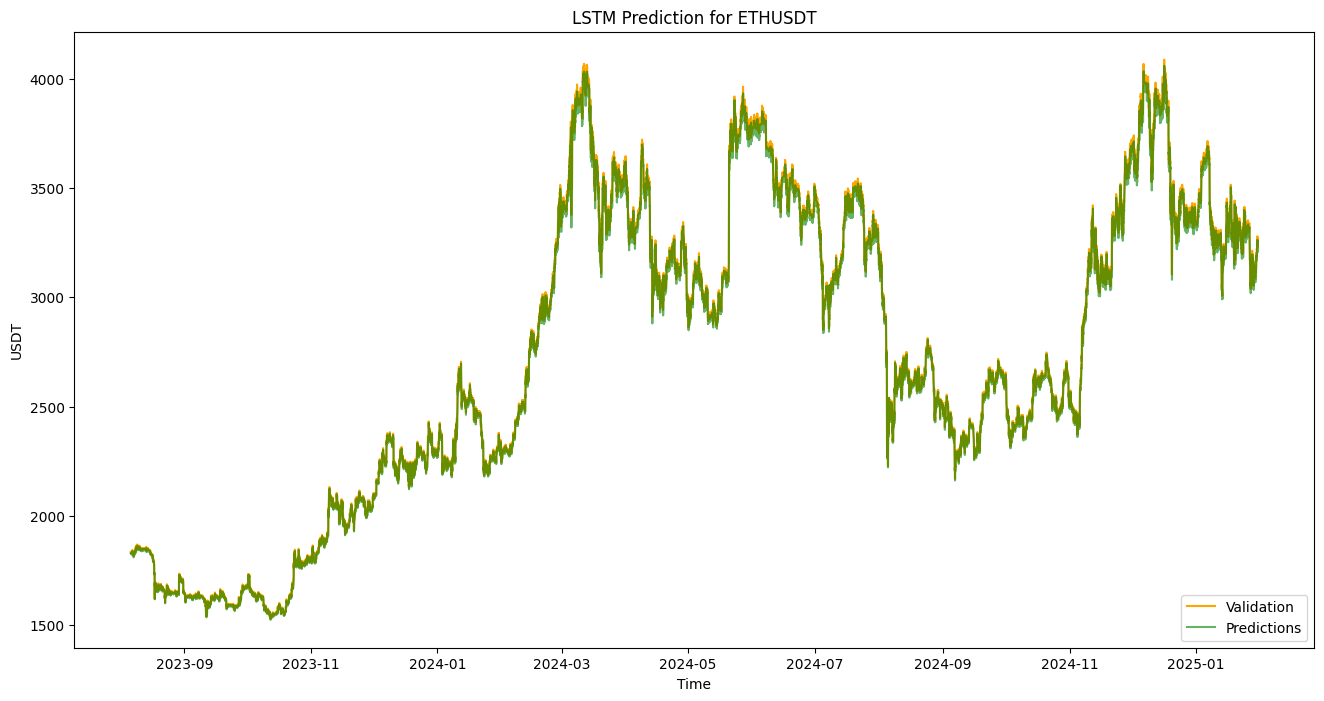

391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


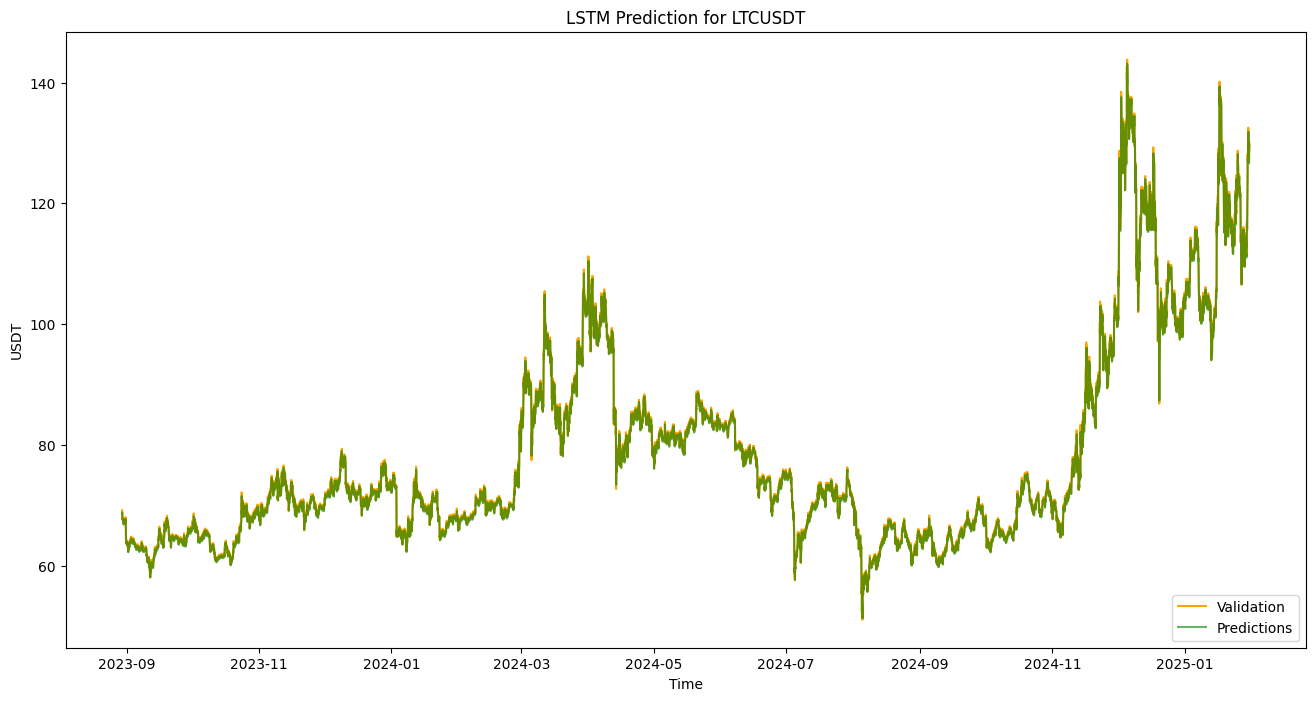

372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


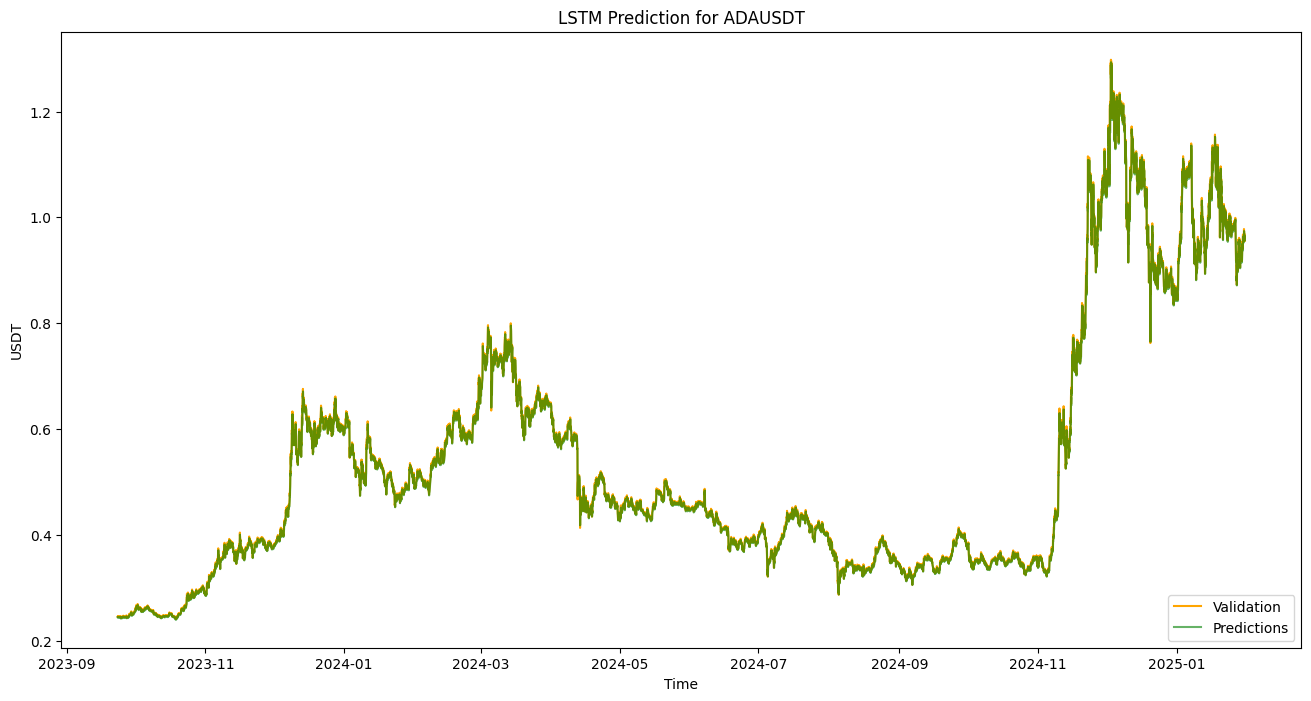

369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


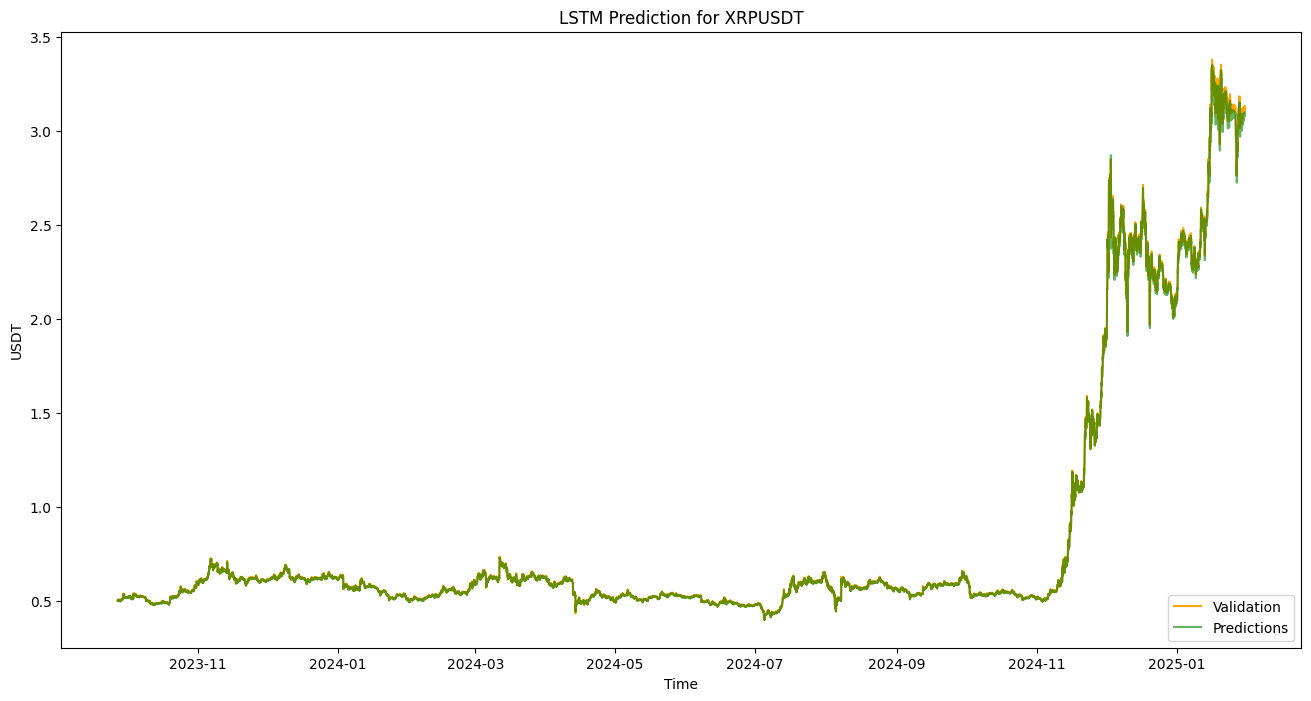

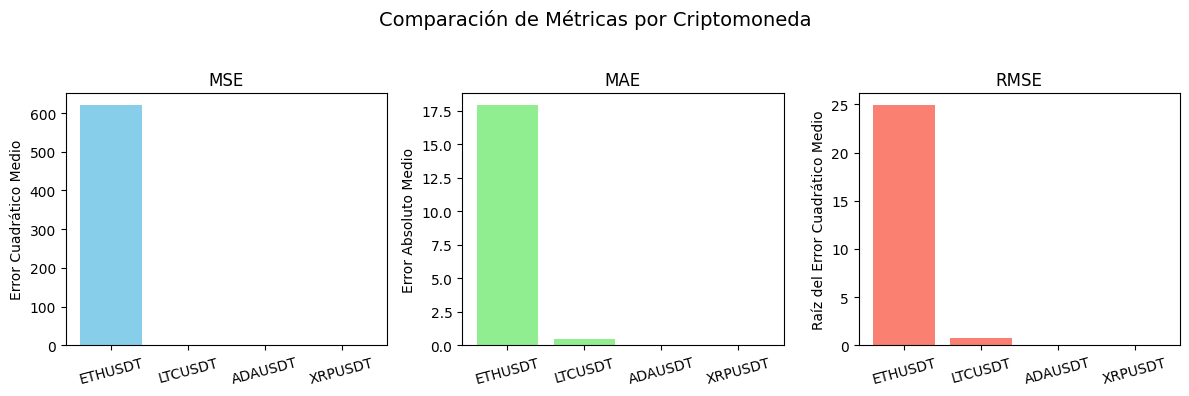

In [7]:
# Listas para métricas de cada criptomoneda
mse_list, rmse_list, mae_list = [], [], []

# Procesamiento y entrenamiento para cada criptomoneda
X_train = np.load("data/X_train.npy")
for crypto in cryptos:
    archivo_csv = f"historical/{crypto}.csv"
    if os.path.exists(archivo_csv):
        headers = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]
        data = pd.read_csv(archivo_csv, names=headers)
        data["Open Time"] = data["Open Time"].apply(calculate_time)
        data["Close Time"] = data["Close Time"].apply(calculate_time)
        close = data.filter(["Close"])
        close_array = close.values
        train_close_len = math.ceil(len(close_array) * 0.8)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(close_array)
        train_data = scaled_data[:train_close_len, :]
        
        wz = 24*7
        test_data = scaled_data[train_close_len - wz:, :]
        X_test = [test_data[i - wz:i, 0] for i in range(wz, len(test_data))]
        X_test = np.array(X_test)
        y_test = scaled_data[train_close_len:, 0]
        
        # Construcción del modelo LSTM
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(100, return_sequences=False))
        model.add(Dense(50))
        model.add(Dense(1))
        model.compile(optimizer="adam", loss="mean_squared_error")
        
        # Cargar pesos del modelo optimizado
        model.load_weights("optimized_model.weights.h5")
        
        # Predicciones
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions)
        
        # Visualización
        dates = np.array(data["Close Time"].values)
        valid = scaler.inverse_transform(y_test.reshape(-1, 1))
        
        plt.figure(figsize=(16, 8))
        plt.title(f"LSTM Prediction for {crypto}")
        plt.xlabel("Time")
        plt.ylabel("USDT")
        plt.plot(dates[train_close_len:], valid, color="orange")
        plt.plot(dates[train_close_len:], predictions, alpha=0.6, color="green")
        plt.legend(["Validation", "Predictions"], loc="lower right")
        plt.show()
        
        mse = np.mean(np.square(valid - predictions))
        rmse = math.sqrt(mse)
        mae = np.mean(np.abs(valid - predictions))
        
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)

# Comparación de métricas
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Comparación de Métricas por Criptomoneda", fontsize=14)

# MSE
axes[0].bar(cryptos, mse_list, color="skyblue")
axes[0].set_title("MSE")
axes[0].set_ylabel("Error Cuadrático Medio")

# MAE
axes[1].bar(cryptos, mae_list, color="lightgreen")
axes[1].set_title("MAE")
axes[1].set_ylabel("Error Absoluto Medio")

# RMSE
axes[2].bar(cryptos, rmse_list, color="salmon")
axes[2].set_title("RMSE")
axes[2].set_ylabel("Raíz del Error Cuadrático Medio")

# Ajustar etiquetas del eje x
for ax in axes:
    ax.set_xticklabels(cryptos, rotation=15)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()